# Анализ продаж компьютерных игр

**Описание исследования:**  

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Цели исследования:**
1. Определить наиболее популярные игры в актуальный период;
2. Определить, какие параметры влияют на популярность компьютерных игр;
3. Составить портрет пользователя компьютерных игр в разных регионах;
4. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
5. Средние пользовательские рейтинги жанров Action и Sports разные.

##  Чтение файла и изучение общей информации

In [1]:
# Импорт библиотек.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

# Настройки.
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
# Загрузка данных.
df = pd.read_csv('games.csv')
df.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,"2,006.00",Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,"1,985.00",Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.00",Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,"2,009.00",Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.00",Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
# Посмотрим на информацию о датасете.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Базовые проблемы датасета
1. Заголовки столбцов записаны в разном регистре.
2. Значения из столбцов `'Name'`, `'Platform'`, `'Genre'` записаны в разном регистре.
3. В столбцах `'Critic_Score'`, `'User_Score'`, `'User_Score'` - есть пропущенные значения.

Теперь нам необходимо узнать, есть ли в датасете явные и неявные дубликаты, а также проанализировать пропуски.

In [4]:
# Приведем сразу имена столбцов к нижнему регистру.
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [5]:
# Подсчитаем процент пропущенных значений в каждом столбце.
percent_missing = df.isna().mean() * 100
percent_missing

name               0.01
platform           0.00
year_of_release    1.61
genre              0.01
na_sales           0.00
eu_sales           0.00
jp_sales           0.00
other_sales        0.00
critic_score      51.32
user_score        40.09
rating            40.48
dtype: float64

Количество пропусков в столбцах `'name'` и `'genre`' - одинаково. Надо посмотреть не связаны ли они друг с другом?

In [6]:
# Отфильтруем пропуски в столбце 'name' и 'genre'.
df[df['name'].isna() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,"1,993.00",NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,"1,993.00",NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [7]:
# Проверим датасет на явные дубликаты.
df.duplicated().sum()

0

In [8]:
# Посмотрим на уникальные значения во всех столбцах типа 'object'.
for col in df.select_dtypes(include='object').columns:
    print('Уникальные значения столбца', col)
    print(df[col].unique(), '\n')

Уникальные значения столбца name
['Wii Sports' 'Super Mario Bros.' 'Mario Kart Wii' ...
 'Woody Woodpecker in Crazy Castle 5' 'LMA Manager 2007'
 'Haitaka no Psychedelica'] 

Уникальные значения столбца platform
['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX'] 

Уникальные значения столбца genre
['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy' nan] 

Уникальные значения столбца user_score
['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.

In [9]:
# Расчет количества уникальных значений в столбце 'name'.
len(df['name'].unique())

11560

In [10]:
# Проверка на дубликаты в столбце 'name'.
df[df.duplicated(subset='name') == True].head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
23,Grand Theft Auto V,X360,"2,013.00",Action,9.66,5.14,0.06,1.41,97.00,8.1,M
35,Call of Duty: Black Ops II,X360,"2,012.00",Shooter,8.25,4.24,0.07,1.12,83.00,4.8,M
37,Call of Duty: Modern Warfare 3,PS3,"2,011.00",Shooter,5.54,5.73,0.49,1.57,88.00,3.2,M
41,Call of Duty: Black Ops,PS3,"2,010.00",Shooter,5.99,4.37,0.48,1.79,88.00,6.4,M
42,Grand Theft Auto V,PS4,"2,014.00",Action,3.96,6.31,0.38,1.97,97.00,8.3,M


In [11]:
# Посмотрим на уникальные значения столбца 'critic_score'.
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

### Пропуски и дубликаты

1. В столбцах `'critic_score'`, `'user_score'`, `'rating'` содержится существенное количество пропусков: от 40 до 50%.
2. В столбце `'year_of_release'` содержится 1.61% пропусков.
3. Столбцы `'name'`, `'genre'` содержат 2 связанных друг с другом пропуска.
4. В столбце `'name'` содержится 11560 уникальных значений, при общем количестве значений -- 16713.
5. В столбце `'user_score'` содержится неизвестное строковое значение 'tbd', что не позволяет ему быть типом float.

###  Вывод  

**Introduction:**  
  
Перед нами модифицированный датасет, загруженный 5 лет назад на платформу Kaggle пользователем Rush Kirubi, датасайентистом из компании Verisk: консалтинговая фирма, изучающая и оценивающая различные риски. Rush Kirubi собрал датасет с помощью скрапера, который 9 лет назад выложил на GuiHub пользователь kareemy. Так как Kareemy отказался от поддержки своего проекта в актуальном состоянии, его код перестал работать и собирать информацию с сайтов vgchartz.com и metacritic.com. По этой причине датасет не обновлялся уже несколько лет. И мы вынуждены работать с тем, что есть. 

1. Заголовки столбцов датасета были написаны в разных регистрах, для удобства мы привели их всех к нижнему.
2. Столбец `'name'` содержит 11560 уникальных значения. Точнее оригинальных, что более верно, для этого столбца. Так как игры с одним и тем же названием выпускались для разных платформ, а также одна и та же игра имела продолжение, мы имеем 5153 повтора, которые не являются дубликатами. Возможно, в этом столбце есть неявные дубликаты. Далее мы приведем значения этого столбца к нижнему регистру. В столбце есть два пропущенных значения, которые мы просто удалим. 
3. Столбец `'platform'` не содержит ни пропущенных значений, ни дубликатов. Никаких действий с ним производить не будем.
4. Столбец `'year_of_release'` содержит 1.61% пропущенных значений. Так как значения этого столбца нам необходимы для дальнейшего исследования, возможны две стратегии: удалить пропуски (они составляют менее 5% от всего датасета и мы не должны потерять важные данные), попытаться их восстановить. Стратегия будет выбрана в последующих шагах исследования.
5. Столбец `'genre'` не содержит дубликтов. Содержит два пропуска, которые будут удалены после удаления двух пропущенных значений из столбца `'name'`.
6. Столбцы `'na_sales'`, `'eu_sales'`, `'jp_sales'`, `'other_sales'` - не содержат пропусков. Но возможно могут содержать нулевые значения в одной строчке. На них будет интересно взглянуть.
7. Столбец `'critic_score'` 51.32% пропущенных значений. Это довольно много, особенно с учетом необходимости исследовать как влиют на продажи игр оценки пользователей и критиков внутри одной популярной платформы. Восстановить значения этого столбца мы не сможем, а вот подойти к выбору той самой одной популярной платформы, надо будет внимательнее. Возможно, для одной популярной платформы пропущенных значений в этом столбце будет не так уж и много. 
8. Столбец `'user_score'` содержит 40.09% пропущенных значений. В датасете он представлен типом object из-за строкового значения 'tbd'. Мы произведем замену 'tbd', приведем столбец к типу float и на этом закончим обработку. 
9. Столбец `'rating'` содержит 40.48% пропущенных значений. Мы посмотрим, доли пропущенных значений рейтинга для каждого из жанров и будем учитывать эту информацию при формировании выводов. Кроме того, мы изменим коды рейтинга USRB на более удобные и привычные для нас, вроде "18+".

**Объяснение пропусков**  
  
Все пропуски в датасете имеют логическое объяснение: датасет собирался из данных двух сайтов, на которых во время сбора не было полной информации об оценках пользователей и критиков, а также значений рейтинга ESRB для каждой игры. Сайт ESRB не содержит открытой базы данных с рейтингами всех игр, поэтому в течение 5 лет никто не восстановил эти пропуски в датасете. 

**Проблема аббревиатуры 'tbd'**  

В мире геймеров аббревиатура 'tbd' расшифровывается, как 'To Be Determined' (пока не определен). Она может относится, например, к дате выхода игры, ее рейтингу и т.д. В нашем случае, такая аббревиатура означает, что пользовательской оценки у игры нет, а следовательно, значения 'tbd' эквивалентны по смыслу NaN. Ими они и будут заменены в дальнейшем.

## Подготовка данных

### Обработка столбца 'name'

In [12]:
# Приведем к нижнему регистру названия игр в столбце 'name'.
df['name'] = df['name'].str.lower()

# И еще раз проверим его на дубликаты. В резльтате выполнения функции мы должны получить 11560, 
# что будет свидетельствовать об отсутствии в столбце неявных дубликатов.
len(df['name'].unique())

11560

### Обработка столбца 'year_of_release'

Проанализируем пропуски в столбце `'year_of_release'`. Перед нами стоит задача, посмотреть как менялись продажи по платформам. Мы можем удалить данные с пустыми значениями столбца `'year_of_release'` исходя из того, что они составляют менее 5% датасета. Однако мы не знаем их долю в каждой из платформ. Возможен вариант, что все пропуски сосредоточены внутри одной или нескольких платформ, и удалив эти значения, мы потеряем важную информацию о платформах. Чтобы не допустить подобной ошибки, расчитаем долю пропущенных значений `'year_of_release'` для каждой из платформ, где такие пропуски.

In [13]:
# Отфильтруем датасет по пропущенным значениям в столбце 'year_of_release'.
is_not_year = df[df['year_of_release'].isna() == True]

# Заполним пропуски единицами, чтобы к ним можно было применять функции.
is_not_year = is_not_year.fillna({'year_of_release':1})

# Посчитаем сумму пропущенных значений для каждой из платформ.
is_not_year_grouped = is_not_year.groupby('platform')['year_of_release'].sum()

# Сгруппируем датасет по платформам, чтобы получить год появления платформы, год смерти платформы, срок ее жизни,
# среднее значение срока жизни платформы в годах и количество значений столбца 'year_of_release' без пропусков 
# для каждой платформы.
platform_lifetime = df.groupby('platform')['year_of_release'].agg(['min', 
                                                               'max', 
                                                               lambda x: max(x)-min(x), 
                                                               'count'])

# Объединим обе таблицы.
platform_lifetime_merge = platform_lifetime.merge(is_not_year_grouped,
                                                  how='left', 
                                                  left_on='platform', 
                                                  right_on='platform'
                                                 ).dropna()

# Расчитаем долю пропусков столбца с годом выпуска игры для каждой из платформ.
platform_lifetime_merge['ratio'] = platform_lifetime_merge['year_of_release']/platform_lifetime_merge['count']

# Привидем таблицу в удобочитаем вид.
platform_lifetime_merge = platform_lifetime_merge.rename(columns={'<lambda_0>':'difference', 
                                                                  'count':'count_is_years',
                                                                  'year_of_release':'count_isna_years'}
                                                        ).style.format({'ratio': '{:.2%}'})

platform_lifetime_merge

,min,max,difference,count_is_years,count_isna_years,ratio
platform,,,,,,
2600,1980.000000,1989.000000,9.000000,116,17.000000,14.66%
3DS,2011.000000,2016.000000,5.000000,512,8.000000,1.56%
DS,1985.000000,2013.000000,28.000000,2121,30.000000,1.41%
GB,1988.000000,2001.000000,13.000000,97,1.000000,1.03%
GBA,2000.000000,2007.000000,7.000000,811,11.000000,1.36%
GC,2001.000000,2007.000000,6.000000,542,14.000000,2.58%
N64,1996.000000,2002.000000,6.000000,316,3.000000,0.95%
PC,1985.000000,2016.000000,31.000000,957,17.000000,1.78%
PS,1994.000000,2003.000000,9.000000,1190,7.000000,0.59%


Как мы видим, наибольшую долю пропусков, почти 15% содержат данные по платформе Atari 2600. Это хоть и старая приставка, но в свое время ее выпустили тиражом почти в 8 миллионов штук. А значит суммарное значение продаж, в случае удаления пропущенных значений, по этой платформе может оказаться значительно ниже, чем оно есть на самом деле. Следовательно удалять пропуски из столбца `'year_of_release'` -- для решения этой задачи исследования будет неверным шагом.  
  
Теперь возникает вопрос: надо ли восстанавливать пропущенные значения в данном столбце? На наш взгляд, заполнять их неким "средним годом" будет некорректно. У платформ могут быть тучные годы (выпуск популярных игр и большие продажи) и тощие годы. Так как нам в дальнейшем будет необходимо выбирать платформы с наибольшими суммарными продажами и строить распределение по годам, внесение некоего "среднего года", может внести шум в это распределение.  
  
С другой стороны, если мы оставим столбце `'year_of_release'` значения Nan мы потеряем некоторое количество данных по суммарным продажам платформы за весь период ее жизни, и не сможем корректно выбрать платформы с наибольшими суммарными продажами.  
  
Но безвыходных положений не бывает. И мы поступим так. Заполним пропуски нулевым годом. Это с одной стороны, позволит нам сохранить суммарные продажи и выбрать платформы с наибольшим их значением, с другой, при построении распределения учесть нулевой год. Во всех платформах, кроме Atari 2600, нулевой год будет составлять от 0.59% до 2.64%, что не должно сильно сказаться на расспределении. А вот попадет ли приставка Atari 2600 в лидеры -- ещё неизвестно.  

In [14]:
# Заполним пропуски в столбце 'year_of_release'.
df = df.fillna({'year_of_release':0})
df[df['year_of_release'].isna() == True]['year_of_release'].count()

0

In [15]:
# Приведем значения столбца 'year_of_release' к типу int.
df['year_of_release'] = df['year_of_release'].astype('int')

### Обработка столбца 'user_score'

In [16]:
# Заменим значение 'tbd' на Nan.
df['user_score'] = df['user_score'].replace('tbd', np.nan)

# Приведем столбец к типу float.
df['user_score'] = df['user_score'].astype('float')
df['user_score'].dtype

dtype('float64')

### Обработка столбца 'rating'

Мы планировали заменить значения рейтинга ESRB на более понятный формат. Выяснилось, что среди значений рейтинга, есть 'K-A' - это устаревшее обозначение, которое сейчас равнозначно 'E'. А также значение 'RP' («Rating Pending») — «Рейтинг ожидается». Википедия говорит нам, что "данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу". Следовательно:
1. Нам необходимо изменить значения рейтинга следующим образом: {'E':'6+', 'M':'17+', 'T':'13+', 'E10+':'10+', 'K-A':'6+', 'AO':'18+', 'EC':'3+'};
2. Посмотреть сколько игр содержат значение 'RP';
3. И поменять это значение, а также все значения Nan на no_rate, потому как в контексте датасета они будут идентичны.

In [17]:
# Подготовим словать для замены.
rating_dic = {'E':'6+', 'M':'17+', 'T':'13+', 'E10+':'10+', 'K-A':'6+', 'AO':'18+', 'EC':'3+'}

# Передадим словарь методу replace() и посчитаем получившиеся значения.
df = df.replace({'rating':rating_dic})
df['rating'].value_counts()

6+     3993
13+    2961
17+    1563
10+    1420
3+        8
RP        3
18+       1
Name: rating, dtype: int64

А вот и неожиданные результаты. Игр с рейтингом 18+ в датасете всего одна. И это создаст определенные проблемы на этапе ответа на вопрос исследования: влияет ли рейтинг ESRB на продажи в отдельном регионе?  
  
Значений с 'RP' оказалось всего 3. Посмотрим на продажи этих игр. 

In [18]:
df[df['rating'] == 'RP']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13672,clockwork empires,PC,0,Strategy,0.00,0.04,0.00,0.00,58.00,3.80,RP
14270,supreme ruler: cold war,PC,2011,Strategy,0.00,0.03,0.00,0.01,63.00,6.80,RP
16180,wrc: fia world rally championship,PC,0,Racing,0.00,0.01,0.00,0.00,65.00,NaN,RP


Интересно, что ни одна из трех игр не продавалась в США и Японии, но продавалась в Европе. Все три игры имеют оценки от критиков, а две из них имеют оценки от пользователей. Впрочем, это скорее, заметки на полях, сделать определенных выводов из полученной информации нельзя.  
  
А вот что важно, так это причины отсутствия рейтинга у такого большого количества игр. И этому есть объяснение. ESRB начала работать только в 1994 году. К 2003 году организация поставила рейтинг 8 тысячам игр. Нельзя утверждать, что к 2016 году (времени сборки датасета) ESRB успела поставить рейтинг всем существующим играм, к тому времени их было уже довольно много. К тому же ESRB умывает руки как только речь заходит об онлайн играх. Эти игры не получают рейтинг, только пометку: «Game Experience May Change During Online Play». Ну, и нельзя не упомянуть о еще одной причине: получить рейтинг ESRB, скорее всего, хотят крупные издатели, которые занимаются производством игр как бизнесом. Однако игры делают и энтузиасты, и им конечно, рейтинг не нужен. 
  
Нам осталось поменять значение Nan и RP на no_rate. И посчитать долю no_rate в каждом из жанров.

In [19]:
# Заполним пропущенные значения.
df = df.fillna({'rating':'no_rate'})

# Заменим значения.
df = df.replace({'rating':{'RP':'no_rate'}})

In [20]:
# Создадим функцию для группировки рейтинга по группам.
def rate_group(row):
    if row['rating'] != 'no_rate':
        return 'A'
    return 'B'

# Создадим столбец 'rate_group' и заполним его значениями.
df['rate_group'] = df.apply(rate_group, axis=1)

# Создадим сводную таблицу, чтобы посчитать количество значений по группам рейтинга.
rate_genre_grouped = pd.pivot_table(
    df, index='genre',
    columns = 'rate_group',
    values='rating', 
    aggfunc=['count']).reset_index(col_level = 1)

# Переименнуем столбцы в сводной таблице.
rate_genre_grouped.columns = ['genre', 'is_norate', 'is_rate']

# Посчитаем долю каждой группы рейтинга для всех жанров.
sum_rate = rate_genre_grouped['is_norate'] + rate_genre_grouped['is_rate']
rate_genre_grouped['ratio_is_norate'] = rate_genre_grouped['is_norate'] / sum_rate * 100
rate_genre_grouped['ratio_is_rate'] = 100 - rate_genre_grouped['ratio_is_norate']

rate_genre_grouped

,genre,is_norate,is_rate,ratio_is_norate,ratio_is_rate
0,Action,2188,1181,64.95,35.05
1,Adventure,446,857,34.23,65.77
2,Fighting,438,411,51.59,48.41
3,Misc,882,868,50.40,49.60
4,Platform,569,319,64.08,35.92
5,Puzzle,342,238,58.97,41.03
6,Racing,871,378,69.74,30.26
7,Role-Playing,777,721,51.87,48.13
8,Shooter,1019,304,77.02,22.98
9,Simulation,568,305,65.06,34.94


В жанр Shooter 77% игр оказались без рейтинга ESRB. А между тем, этот жанр главный претендент на получение маркировки 18+. Больше всего значений с рейтингом у игр в жанре Adventure, почти 66%. Из 11 жанров более 50% записей с рейтингом содержат только два жанра. 

### Cуммарные продажи во всех регионах

In [21]:
# Запишем суммарные продажи в столбец 'total'.
df['total'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

### Анализ столбцов 'na_sales', 'eu_sales', 'jp_sales', 'other_sales'

Теперь посмотрим, есть ли среди игр те, для которых не были указаны продажи ни в одном регионе.

In [22]:
# Применим фильтр.
df[df['total'] == 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rate_group,total
16676,g1 jockey 4 2008,PS3,2008,Sports,0.00,0.00,0.00,0.00,NaN,NaN,no_rate,B,0.00
16709,score international baja 1000: the official game,PS2,2008,Racing,0.00,0.00,0.00,0.00,NaN,NaN,no_rate,B,0.00


Таких игр всего две. Они не внесут шум в распределения, поэтому можем их оставить.

###  Вывод  
  
1. Мы привели значения столбца `'name'` к нижнему регистру и получили 11560 уникальных значений при подсчете. Эта цифра совпадает с той, что была до обработки столбца, а значит неявных дубликатов в этом столбце не было.

2. Мы проанализировали пропуски в столбце `'year_of_release'` и выяснили, что больше всего данных потеряно для платформы Atari 2600. В этом столбце мы не стали удалять строки с пропусками, а заменили их на "нулевой год", который позволит нам в дальнейшем корректно отобрать платформы с наибольшими суммарными продажами и построить распределение по годам. 

3. Мы заменили в столбце `'user_score'` значение 'tbd' на nan и привели этот столбец к типу float.

4. В столбце `'rating'` мы расшифровали каждое значение рейтинга USRB и выяснили, что два значения дублировали друг друга. Мы заменили значения на более удобный для восприятия формат, обработали пропуски, а также посчитали долю записей с рейтингом и без для каждого жанра.

5. Мы посчитали суммарное значение продаж по всем регионам и выяснили, что всего две игры имеют в этом столбце нулевые значения. Эти строки мы решили оставить в датасете, так как они не окажут серьезного влияния на дальнейшее исследование.

##  Исследовательский анализ данных

Для ответа на поставленные в этой части исследования вопросы, нам потребуются агрегированные данные по годам и платформам. Подготовим их.

In [23]:
# Агрегируем данные по годам.
year_agregation = (
    df.groupby(['year_of_release'])['name', 'total']
    .agg({'name':'count',
          'total':'sum'}).reset_index())

# Агрегируем данные по платформам.
platform_agregation = (
    df.groupby(['platform', 'year_of_release'])
    ['total',
     'name', 
     'na_sales', 
     'eu_sales', 
     'jp_sales', 
     'other_sales',
     'critic_score', 
     'user_score']
    .agg({'name':'count',
          'total':'sum',     
          'na_sales':'sum', 
          'eu_sales':'sum', 
          'jp_sales':'sum', 
          'other_sales':'sum',
          'critic_score':['sum', 'count'],
          'user_score':['sum', 'count']
         }).reset_index())

# Переименнуем столбцы.
platform_agregation.columns = ['platform',
                                'year_of_release',
                                'name_count', 
                                'total_sum', 
                                'na_sales_sum', 
                                'eu_sales_sum', 
                                'jp_sales_sum', 
                                'other_sales_sum', 
                                'critic_score_sum', 
                                'critic_score_count', 
                                'user_score_sum', 
                                'user_score_count']

/tmp/ipykernel_18077/2573671907.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['year_of_release'])['name', 'total']
/tmp/ipykernel_18077/2573671907.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['platform', 'year_of_release'])


Теперь произведем общую настройку графиков.

In [24]:
# Установим размер графика, стиль и размер шрифта.
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(16, 8)})

###  Вопрос №1
  
Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

Мы помним, что у нас в столбце 'year_of_release' сохранились значения "нулевого года", которые на данном этапе внесут грязь в общую картину. Уберем эти значения и построим линейный график по годам, чтобы ответить на поставленный вопрос.

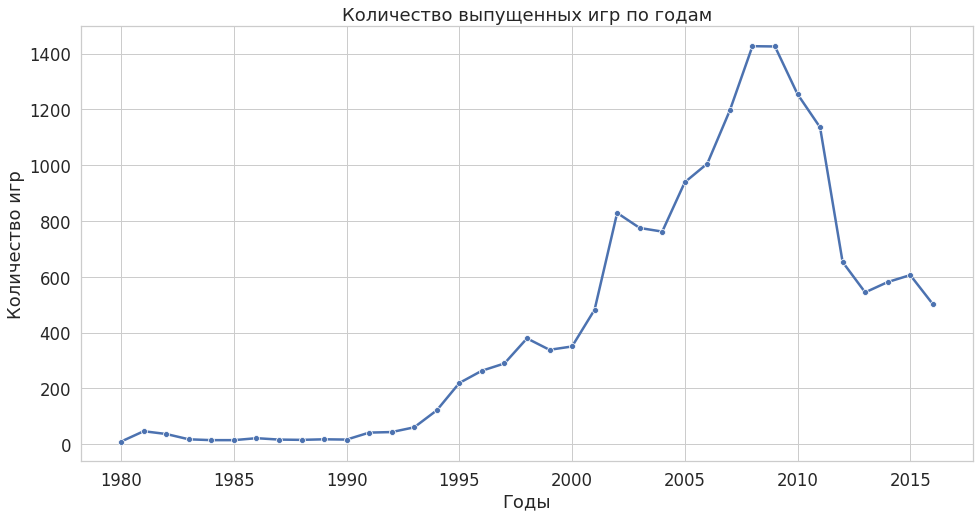

In [25]:
# Убирем значение "нулевого года".
is_not_null_yaers = year_agregation[year_agregation['year_of_release'] != 0]

# Построим график.
sns.lineplot(data=is_not_null_yaers, x='year_of_release', y='name', linewidth=2.5, marker='o')

plt.title('Количество выпущенных игр по годам')
plt.xlabel('Годы')
plt.ylabel('Количество игр')
plt.show()

Начиная с 2004 года наметился резкий рост выпуска компьютерных игр. Своего пика он достиг в 2008-09 годах, после чего пошел на спад. А с 2013 года наблюдается плато. 2008-09 годы - годы мирового экономического кризиса, который, вероятно, смогли пережить не все игроки. С рынка уходили производители игр, происходили поглощения и слияния. Рынок игр выравнился только к 2013 году.

###  Вопрос №2
  
Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [26]:
# Сгруппируем данные по платформам.
(platform_agregation
     .groupby('platform')['total_sum']
     .agg('sum')
     .reset_index()
     .sort_values(by='total_sum', ascending=False))

,platform,total_sum
16,PS2,"1,255.77"
28,X360,971.42
17,PS3,939.65
26,Wii,907.51
4,DS,806.12
15,PS,730.86
6,GBA,317.85
18,PS4,314.14
19,PSP,294.05
13,PC,259.52


Наибольшие суммарные продажи за все время показали 6 платформ PS2, X360, PS3, Wii, DS, PS.  
  
В начале исследования мы ввели "нулевой год", так как у приставки Atari 2600 было почти 15% пропущенных значений. Мы видим, что она занимает 19 место в списке платформ. Таким образом, для целей данного исследования пропуски у Atari 2600 не влияют на ее показатели. Мы также получили Топ-6 лидеров по продажам. Теперь мы можем проверить, влияют ли остальные пропуски на этот список. Если не влияют, мы можем удалить значения "нулевого года", без потери качества исследования.

In [27]:
# Перезапишем переменную без "нулевого года".
is_not_null_platform_agregation = platform_agregation[platform_agregation['year_of_release'] != 0]

# Сгруппируем данные по платформам с этой переменной.
(is_not_null_platform_agregation
     .groupby('platform')['total_sum']
     .agg('sum')
     .reset_index()
     .sort_values(by='total_sum', ascending=False))

,platform,total_sum
16,PS2,"1,233.56"
28,X360,961.24
17,PS3,931.34
26,Wii,891.18
4,DS,802.78
15,PS,727.58
18,PS4,314.14
6,GBA,312.88
19,PSP,289.53
2,3DS,257.81


Как мы видим, значения в `'total_sum'` немного уменьшились, но смещения лидирующих платформ друг с другом не произошло, также как смещения Atari 2006, а следовательно, мы теперь можем окончательно удалить значения "нулевого года".  
И построить распределение по годам у наших платформ-лидеров.

In [28]:
platform_agregation = platform_agregation[platform_agregation['year_of_release'] != 0]

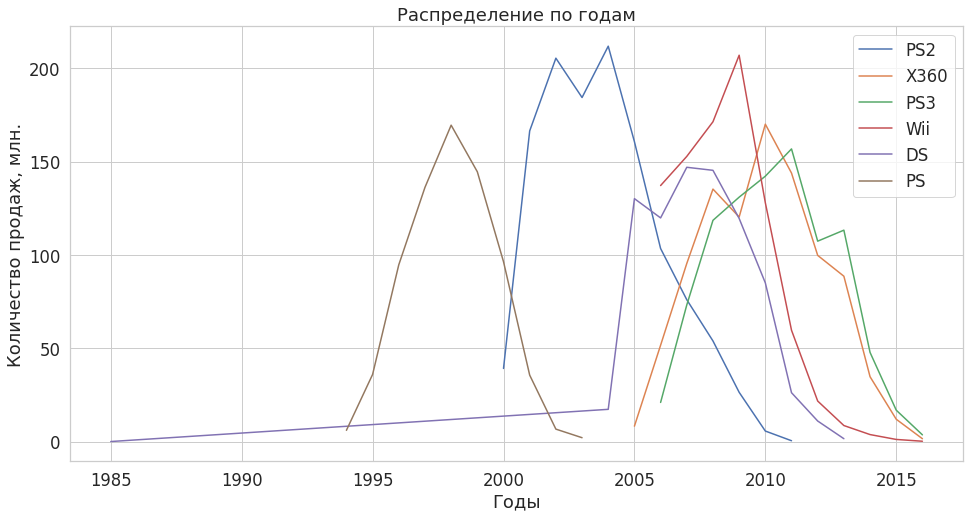

In [29]:
platform_list = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

for platform in platform_list:
    (platform_agregation[platform_agregation['platform'] == platform]
     .groupby('year_of_release')['total_sum']
     .agg('sum')
     .plot(label = platform))    
    
    plt.title(f'Распределение по годам')
    plt.xlabel('Годы')
    plt.ylabel('Количество продаж, млн.')
    plt.legend()

На примере игровой приставки PlayStation хорошо видно, что среднее время жизни платформы составляет 10 лет. Причем наиболее высокое количество продаж приходится на первую половину жизни платформы. И как правило, эти продажи растут резко и быстрыми темпами. Мы видим, что к 16-ому году заканчивается десятилетний цикл всех лидеров продаж 'X360', 'PS3', 'Wii'.  Единственным исключением из этого правила стала платформа PC, она знанимает 13-е место в рейтинге по количеству продаж, но при этом живет с 1985 года, и похоже, нас еще переживет. 

###  Вопрос №3
  
Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

Мы отметили, что 16-ый год ознаменовал эру вымирания платформ-лидеров. Исходя из этого, нам необходимо обратиться к первому графику, в котором мы рассматривали суммарные продажи за все время. Как мы уже отмечали, на этом графике видна граница восстановления рынка игр, начиная с 13-го года. Именно это и станет для нас точкой отсчета актуального периода.  

Так как дальше мы будем работать только с ним, нам необходимо отфильтровать ненужные записи из наших агрегированных данных.

In [30]:
# Отфлильтруем данные. 
year_agregation = year_agregation[year_agregation['year_of_release'] >= 2013]
platform_agregation = platform_agregation[platform_agregation['year_of_release'] >= 2013]

###  Вопрос №4
  
Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Для начала посмотрим, какие платформы остались в нашем списке после фильтрации, и какие из них занимают лидирующее положение на рынке?

In [31]:
# Сгруппируем данные по платфомам.
(platform_agregation
     .groupby('platform')['total_sum']
     .agg('sum')
     .reset_index()
     .sort_values(by='total_sum', ascending=False))

,platform,total_sum
4,PS4,314.14
3,PS3,181.43
10,XOne,159.32
0,3DS,143.25
9,X360,136.80
8,WiiU,64.63
2,PC,39.43
6,PSV,32.99
7,Wii,13.66
5,PSP,3.50


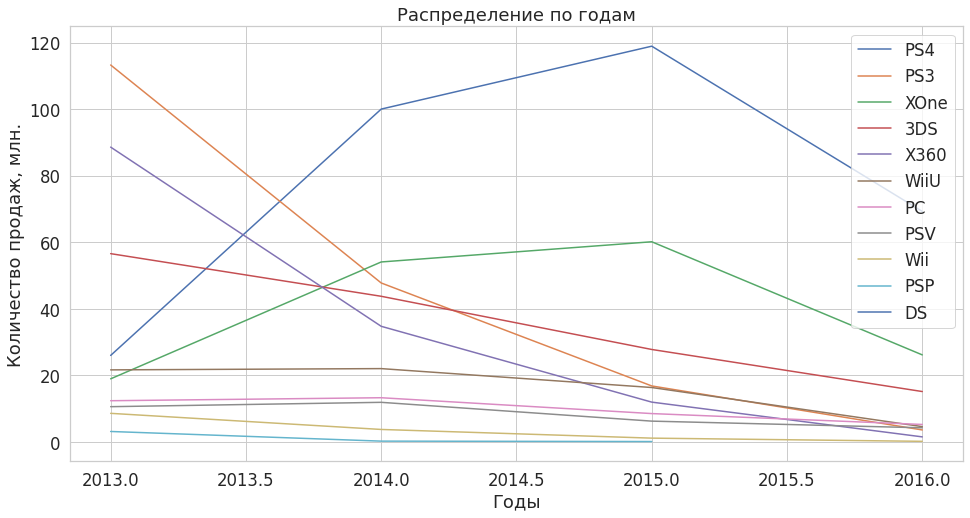

In [32]:
actual_platform_list = ['PS4', 'PS3', 'XOne', '3DS', 'X360', 'WiiU', 'PC', 'PSV', 'Wii', 'PSP', 'DS']

for platform in actual_platform_list:
    (platform_agregation[platform_agregation['platform'] == platform]
     .groupby('year_of_release')['total_sum']
     .agg('sum')
     .plot(label = platform))    
    
    plt.title(f'Распределение по годам')
    plt.xlabel('Годы')
    plt.ylabel('Количество продаж, млн.')
    plt.legend()

Абсолютный лидер по продажам в актуальный период платформа PS4. PS3, XOne, 3DS, X360 отстают от нее в 1.5-2 раза. В тоже время мы видим, что продажи по всем платформам падают. На фоне падающих продаж наиболее привлекательно выглядят PS4, XOne и 3DS. Остальные спустились на уровень 5 млн. в год по всему миру, что можно считать просто каплей в море. На графике также видно, что платформы PS4 и XOne прошли пики своих продаж в 2014 году, а следовательно в следующие 5 лет продажи игр для этих платформ будут каждый год сокращаться.

###  Вопрос №5
  
Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

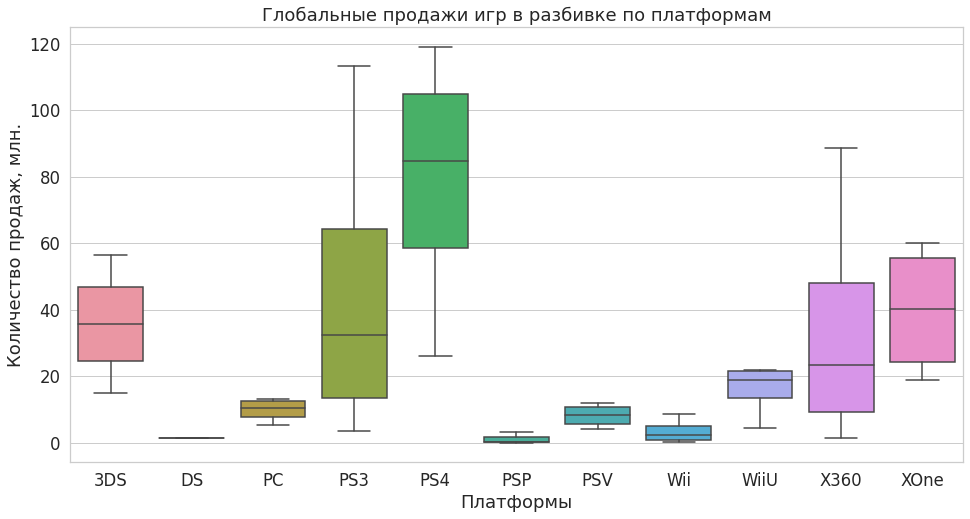

In [33]:
# Создадим переменные.
x = platform_agregation["platform"]
y = platform_agregation["total_sum"]

# Построим график "ящик с усами"
sns.boxplot(x=x, y=y)

plt.title(f'Глобальные продажи игр в разбивке по платформам')
plt.xlabel('Платформы')
plt.ylabel('Количество продаж, млн.')

plt.show()

Наибольший интерес на графике представляют пять платформ, трех производителей. PS4, PS3, XOne, 3DS, X360. Сразу бросается в глаза смещение влево среднего у платформ PS3 и X360. Что естетественно, так как продажи игр для этих игровых приставок падают уже на протяжении пяти лет. По правому усу PS3 и размеру бокса видно, что она была популярнее X360. И на этом плохие новости для Microsoft не заканчиваются. Приемница X360 -- XboxOne проиграла по полной программе конкуренцию PS4. Даже пиковые значения продаж игр для XboxOne едва заходят в первый квартиль PS4. И даже портативная игровая приставка Nintendo 3DS своим идеальным средним на XboxOne выглядит более убедительно. Время рекордов PS4 уже прошло, но шлейф популярности сохранит продажи игр для этой приставки на хорошем уровне еще несколько лет. Ну, и похоже выбор для решения следующей задачи очевиден. Посмотрим, как влияют на продажи игр отзывы критиков и пользователей.

###  Вопрос №6
  
Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

In [34]:
# Отфильтруем датасет по названию платформы.
scores_ps4 = df[df['platform'] == 'PS4']

In [35]:
# Создадим функцию для построения диаграммы. 
def scores_scatterplot(data, x, y, title_name):
    sns.scatterplot(data=data, 
                    x=x, 
                    y=y, 
                    hue='year_of_release', 
                    s=100,
                    palette='viridis',
                    alpha=0.5
                   )
    plt.title(title_name)
    plt.xlabel('Оценка')
    plt.ylabel('Количество продаж, млн.')
    plt.show()   

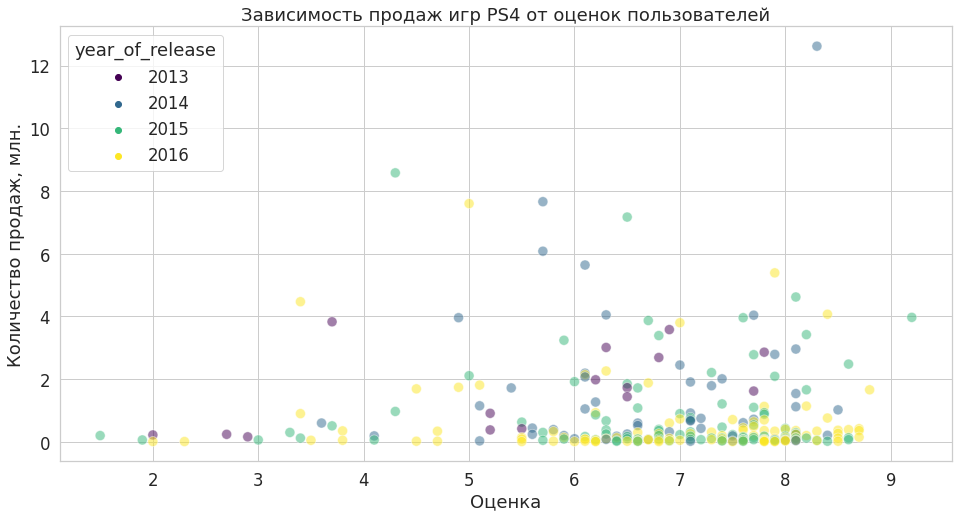

In [36]:
# Построим диаграмму рассеяния для отзывов пользователей.
scores_scatterplot(scores_ps4, 'user_score', 'total', 'Зависимость продаж игр PS4 от оценок пользователей')

Мы наблюдаем странную картину, а именно отсутствие заметной связи между отзывами пользователей и количеством проданных игр. Особенно хорошо, это заметно по 2016 году. Высокие пользовательские оценки буквально прибиты к нижней части графика. Это явление мы назвали странным, так как обычно считается, что отзывы и высокие пользовательские оценки делают какой-либо продукт более популярным, не зря же этот инструмент используется повсеместно. Вопрос, почему в нашем случае оценки юзеров никак не влияют на продажи? Ответов может быть несколько: 
1. Пользовательские оценки увеличивают продажи на доли процентов, которые мы не видим в масштабе графика;
2. У нас есть только небольшая доля пользовательских оценок по всем играм. Этой информации может быть недостаточно, чтобы проявилась зависимость. Проверить второе предположение можно, расчитав, сколько пользовательских оценок есть у каждой игры. 

In [37]:
# Посчитаем количество игр.
print(scores_ps4['name'].count(), '- количество игр')

# Посчитаем количество оценок пользователей.
(print(scores_ps4[scores_ps4['user_score'].isna() == False]
       ['user_score'].count(), '- количество оценок пользователей'))

# Найдем игру с максимальным количеством пользовательских оценок.
(print(scores_ps4[scores_ps4['user_score'].isna() == False]
       .groupby('name')['user_score']
       .agg('count')
       .max(),
       '- максимальное количество оценок'))

392 - количество игр
257 - количество оценок пользователей
1 - максимальное количество оценок


А вот и ответ на вопрос. На 392 игры в датасете всего 257 оценок пользователей. И максимально на одну игру, у которой есть оценки, приходится всего одна оценка. Естественно, это не позволяет проследить зависимость продажи игр от оценок пользователей.

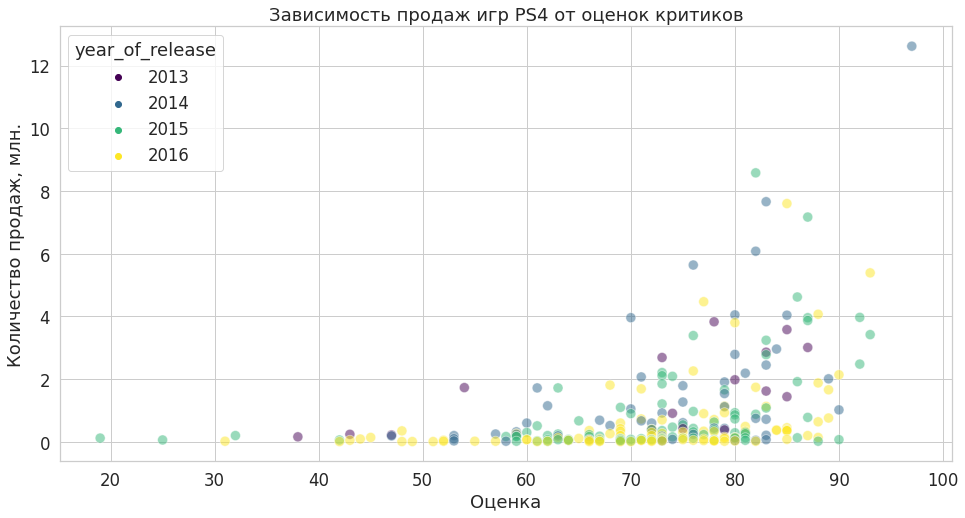

In [38]:
# Построим диаграмму рассеяния для отзывов критиков.
scores_scatterplot(scores_ps4, 'critic_score', 'total', 'Зависимость продаж игр PS4 от оценок критиков')

На этом графике уже заметна небольшая зависимость роста продаж от высоких оценок критиков. Но насколько она объективна или носит случайный характер?

In [39]:
# Посчитаем количество оцеок критиков.
(print(scores_ps4[scores_ps4['critic_score'].isna() == False]
       ['critic_score'].count(), '- количество оценок критиков'))

# Найдем игру с максимальным количеством оценок критиков.
(print(scores_ps4[scores_ps4['critic_score'].isna() == False]
       .groupby('name')['critic_score']
       .agg('count')
       .max(),
       '- максимальное количество оценок'))

252 - количество оценок критиков
1 - максимальное количество оценок


Оценок критиков оказалось еще меньше, чем оценок пользователей. И их максимальное количество на одну игру - также одна. А следовательно зависимость, которую мы увидели на графике - можно считать случайностью. Объективной информации о корреляции получить невозможно из-за отсутствия достаточного количества данных.

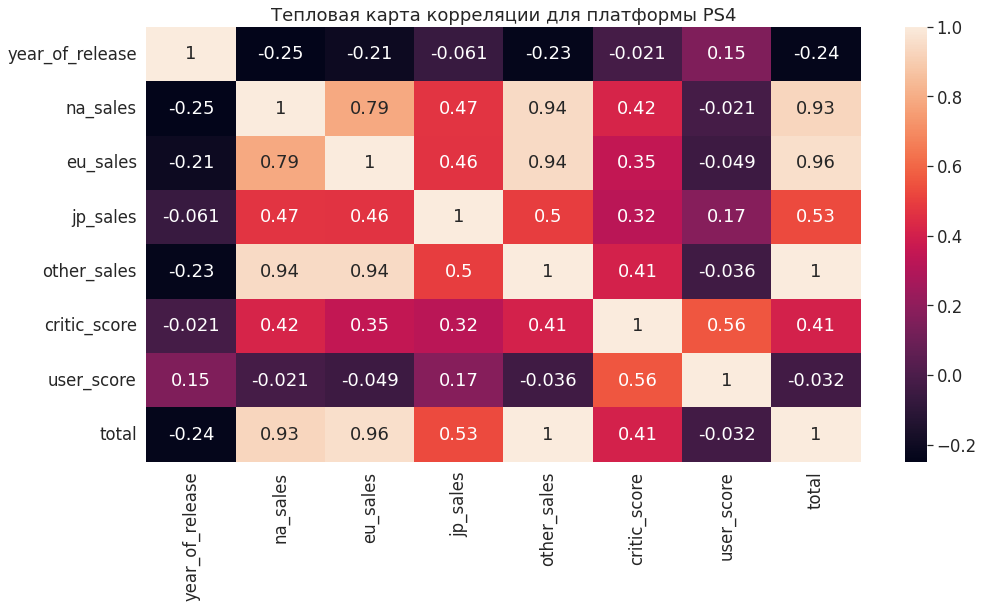

In [40]:
# Посмотрим на корреляцию между продажами и отзывами пользователей и критиков на тепловой карте.
sns.heatmap(scores_ps4.corr(), annot=True)
plt.title('Тепловая карта корреляции для платформы PS4')
plt.show()

Тепловая карта демонстрирует нам те явления, которые мы отметили выше. Показывает отрицательную очень слабую корреляцию - -0.032 между глобальными продажами и оценками пользоватлей, и умеренную корреляцию 0.41 между глобальными продажами и оценками критиков. Однако считать эти показатель объективными, мы не можем

###  Вопрос №7
  
Соотнесите выводы с продажами игр на других платформах.

In [41]:
# Отфильтруем датасет по году и платформам.
scores_all = df[df['year_of_release'] >= 2013]
scores_all = scores_all[scores_all['platform'] != 'PS4']

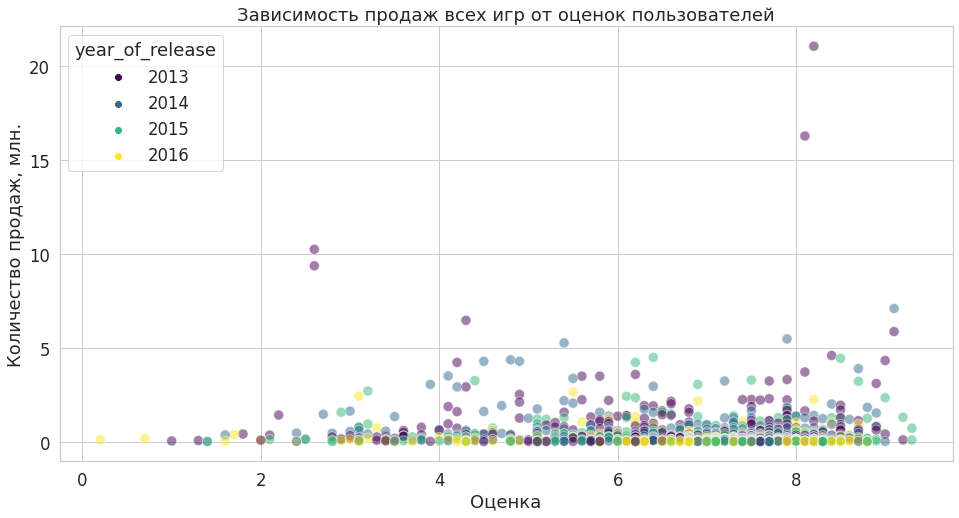

In [42]:
# Построим диаграмму рассеяния для отзывов пользователей.
scores_scatterplot(scores_all, 'user_score', 'total', 'Зависимость продаж всех игр от оценок пользователей')

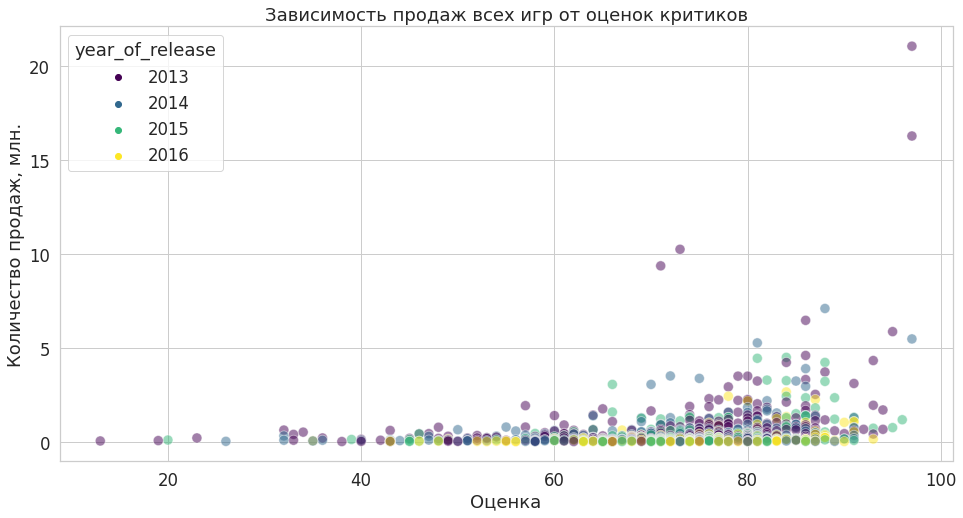

In [43]:
# Построим диаграмму рассеяния для отзывов критиков.
scores_scatterplot(scores_all, 'critic_score', 'total', 'Зависимость продаж всех игр от оценок критиков')

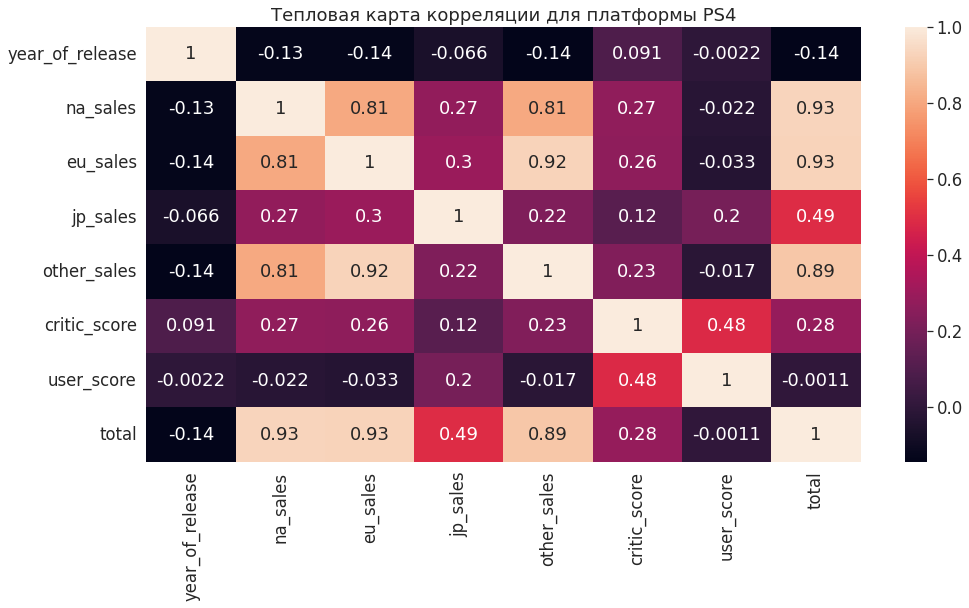

In [44]:
# Посмотрим на корреляцию между продажами и отзывами пользователей и критиков на тепловой карте.
sns.heatmap(scores_all.corr(), annot=True)
plt.title('Тепловая карта корреляции для платформы PS4')
plt.show()

По другим платформам мы получили еще более низкую корреляцию. Для пользовательских оценок -0.0011, для оценок критиков 0.28.

###  Вопрос №8
  
Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Сначала посмотрим на количество проданных игр каждого жанра

In [45]:
# Актуализируем данные.
genre_agregation = df[df['year_of_release'] >= 2013]

# Агрегируем данные.
genre_distribution = (
    genre_agregation.groupby('genre')
    ['total']
    .agg('count')
    .reset_index()
)

In [46]:
# Отсортируем данные, чтобы посмотеть количество выпущенных игр для каждого жанра.
genre_distribution.sort_values(by='total', ascending=False)

,genre,total
0,Action,766
7,Role-Playing,292
1,Adventure,245
10,Sports,214
8,Shooter,187
3,Misc,155
6,Racing,85
2,Fighting,80
4,Platform,74
9,Simulation,62


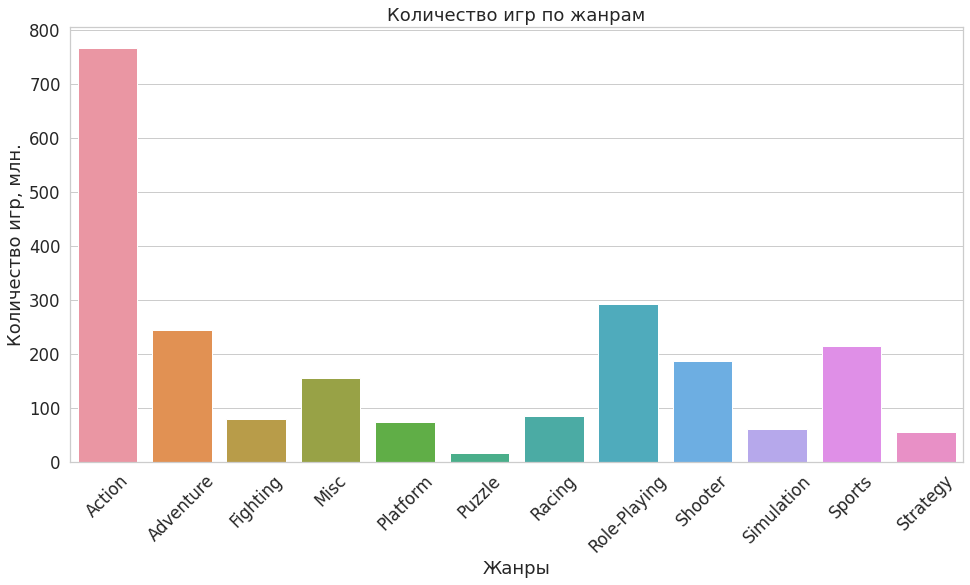

In [47]:
# Отобразим визуально распределение
data = genre_distribution
x = 'genre'
y = 'total'

sns.barplot(data=data, x=x, y=y)

plt.title('Количество игр по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Количество игр, млн.')
plt.xticks(rotation=45)
plt.show() 

По числу выпущенных игр лидирует жанр Action. В топ-5 наиболее распространненных игр вошли также Role-Playing, Adventure, Sports, Shooter. Теперь посмотрим на доли каждой игры в продажах.

In [48]:
# Агрегируем данные.
top_sale = (
    genre_agregation.groupby('genre')
    ['total']
    .agg('mean')
    .reset_index()
)

In [49]:
# Отсортируем данные, чтобы посмотеть долю каждой игры.
top_sale.sort_values(by='total', ascending=False)

,genre,total
8,Shooter,1.25
10,Sports,0.70
4,Platform,0.58
7,Role-Playing,0.50
6,Racing,0.47
2,Fighting,0.44
0,Action,0.42
3,Misc,0.41
9,Simulation,0.35
5,Puzzle,0.19


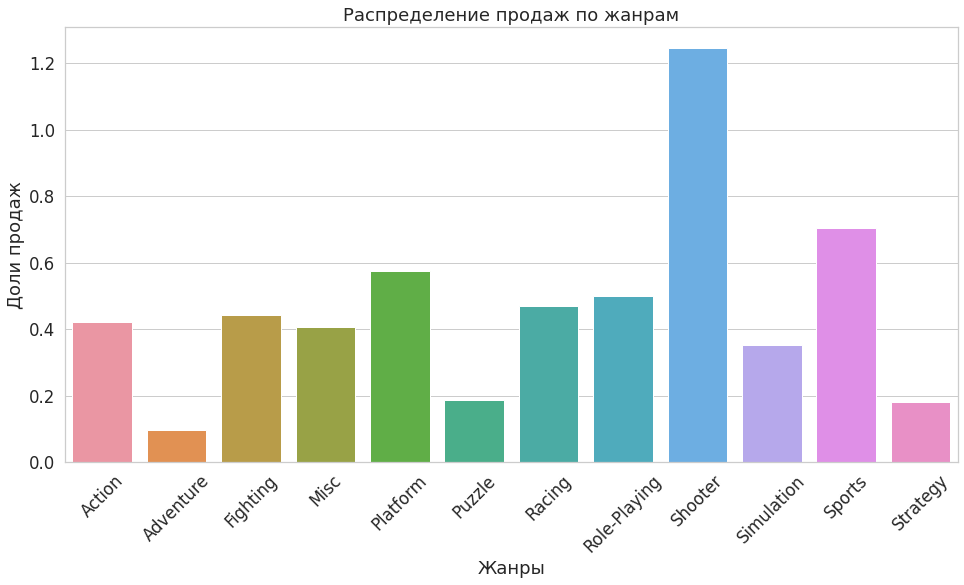

In [50]:
# И построим гистограмму. 
data = top_sale
x = 'genre'
y = 'total'

sns.barplot(data=data, x=x, y=y)

plt.title('Распределение продаж по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Доли продаж')
plt.xticks(rotation=45)
plt.show() 

А вот здесь уже другая картина. Самую высокую долю в продажах занимает жанр Shooter, за ним следуют: Sports, Platform и Role-Playing. Жанр Action в продажах занимает только седьмое место.

Антитоп по продажам заняли игры в жанре: Misc, Simulation, Puzzle, Strategy, Adventure. 

###  Вывод

1. Мы выяснили, что рынок продаж компьютерных игр после стремительного роста с 95 года, в 2008-09 года вышел на пик, а после ушел в резкое падения и стабилизировался только к 2013 году. Этот год стал отправной точкой, актуальным периодом для нашего исследования.
2. Наибольшие суммарные продажи за все время показали 6 платформ PS2, X360, PS3, Wii, DS, PS.
3. Мы выяснили, что среднее время жизни платформы составляет 10 лет. 
4. Мы выяснили, что самой популярной платформой в актуальный период является PS4, а ее ближайший конкурент XboxOne серьезной проигрывает в продажах игр.
5. Мы выяснили, что у нас нет достаточного количества данных, чтобы определить взаимосвязь между продажами и оценками пользователей и критиков. Те данные, что у нас были, показали практическое отсутствие корреляции между этими параметрами.
6. Мы выяснили, что в топ-3 самых прибыльных жанров входят Shooter, Sports, Platform и Role-Playing, а антитоп по прибыли заняли игры в жанре: Misc, Simulation, Puzzle, Strategy, Adventure.

## Составление портрета пользователя каждого региона

### Самые популярные платформы (топ-5). 
Опишите различия в долях продаж.

In [51]:
# Сгруппируем продажи в разных регионах по платформам и получим доли продаж для каждой платформы в каждом регионе.
top_platform = (
    platform_agregation.groupby('platform')
    ['na_sales_sum', 
     'eu_sales_sum', 
     'jp_sales_sum', 
     'other_sales_sum', 
     'total_sum']
    .agg('mean')
    .transform(lambda x: x/np.sum(x)*100)
    .reset_index()
)

# Сделаем срез долей по интересующим нас регионам.
top_platform = top_platform.loc[:,['platform', 'na_sales_sum', 'eu_sales_sum', 'jp_sales_sum']]

# Изменим названия столбцов.
top_platform.columns = ['platform', 
                        'north_america', 
                        'europa', 
                        'japan']
top_platform

/tmp/ipykernel_18077/3581407543.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  platform_agregation.groupby('platform')


,platform,north_america,europa,japan
0,3DS,8.69,7.84,47.80
1,DS,0.52,0.86,0.00
2,PC,2.53,6.42,0.00
3,PS3,14.45,17.17,16.46
4,PS4,24.75,35.73,11.25
5,PSP,0.00,0.06,3.09
6,PSV,1.15,1.54,13.10
7,Wii,1.49,1.50,0.04
8,WiiU,6.65,5.03,7.67
9,X360,18.58,10.77,0.36


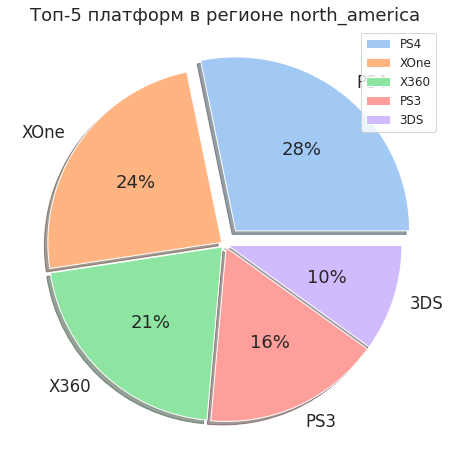

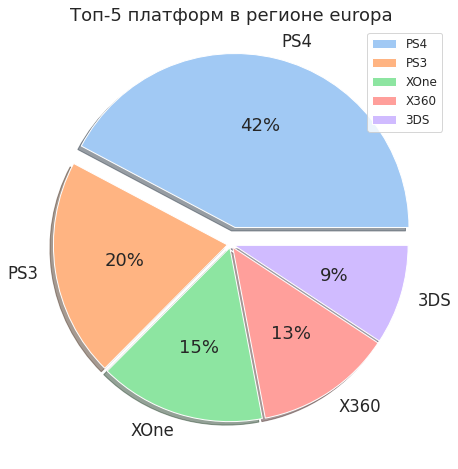

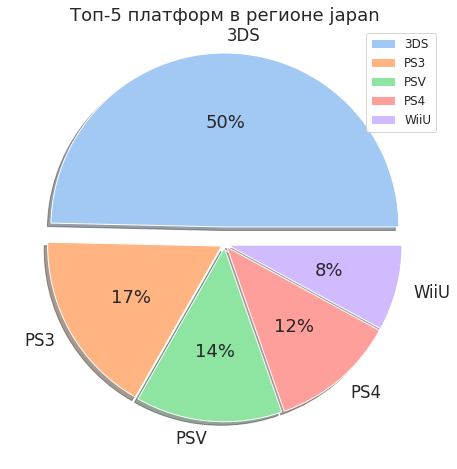

In [52]:
# Создадим цикл, в коротом переберм все регионы. Для каждого из них отсортируем данные по убыванию и сделаем срез
# первых пяти значений - это и будет наш ТОП-5 по платформам.
for region in ['north_america', 'europa', 'japan']:
    top_five_platform = top_platform.sort_values(region, ascending=False)[0:5]

# Для визуализации построим график типа pie.
    data = top_five_platform[region]
    explode = [0.1, 0.02, 0.02, 0.02, 0.02]
    labels = top_five_platform['platform']
    colors = sns.color_palette('pastel')
    
    plt.pie(data, labels=labels, colors=colors, shadow='True', autopct='%0.0f%%', explode=explode)
    
    plt.title(f'Топ-5 платформ в регионе {region}')
    plt.legend(fontsize=12)
    plt.show()

Пользователи в Северной Америке предпочитают играть на приставках PS4, XOne и X360. Их доли составляют более 50%. Последние две приставки производства компании Microsoft. Что может свидетельствовать либо о патриотических, либо об экономических мотивах выбора платформ.

Европейские пользователи отдают предпочтения приставкам компании Sony. Доли PS4 и PS3 в этом регионе превышают 60%. На третьем месте - XOne.

Американские в европейские пользователи также не отказывают себе в удовольствии поиграть на портативной игровой системе производства компании Nintendo. Эта платформа замыкает пятерку лидеров в обоих регионах.

А вот японские геймеры отдают явное предпочтение портативной 3DS. Ее доля в этом регионе 50%. А с учетом вхождения в топ PSV - можно сделать вывод, что в Японии предпочитают портативные консоли. Их общая доля 64%. Ни одна американская платформа не попала в Топ-5 в Японии. Показательно.

### Самые популярные жанры (топ-5). 
Поясните разницу.

In [53]:
# Агрегируем данные, получим доли продаж по жанрам в каждом регионе.
top_region_genre = (
    df.groupby(['genre'])
    ['na_sales', 
     'eu_sales', 
     'jp_sales']
    .agg('mean')
    .transform(lambda x: x/np.sum(x)*100)
    .reset_index()
)

/tmp/ipykernel_18077/3021130941.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['genre'])


In [54]:
# Переименнуем столбцы.
top_region_genre.columns = ['genre', 
                            'north_america', 
                            'europa', 
                            'japan']

Создадим цикл, в коротом переберем все жанры. Для каждого из них отсортируем данные по убыванию и сделаем срез первых пяти значений - это и будет наш ТОП-5 по жанрам.

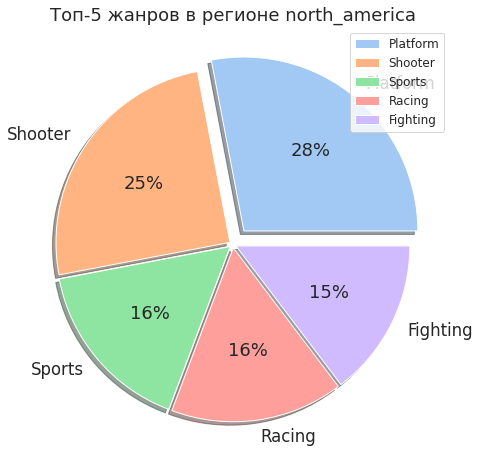

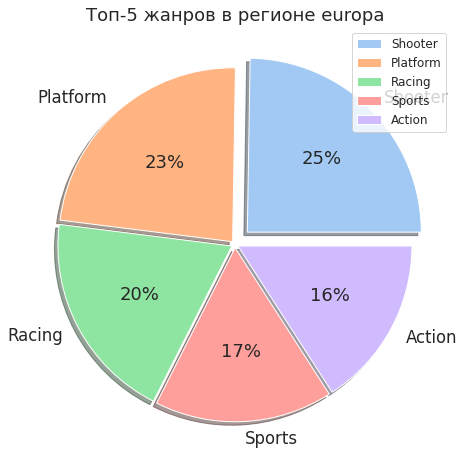

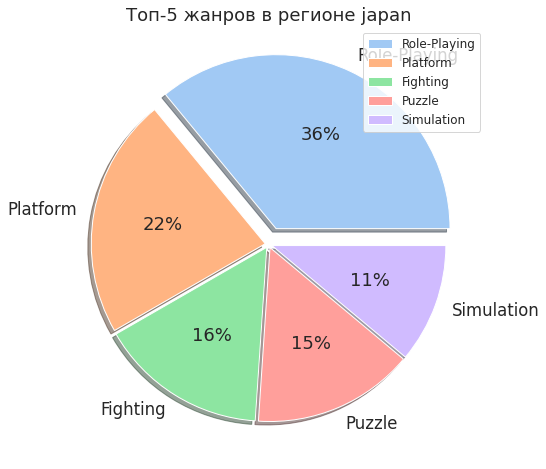

In [55]:
for region in ['north_america', 'europa', 'japan']:
    top_five_genre = top_region_genre.sort_values(region, ascending=False)[0:5]

# Для визуализации построим график типа pie.
    data = top_five_genre[region]
    explode = [0.1, 0.02, 0.02, 0.02, 0.02]
    labels = top_five_genre['genre']
    colors = sns.color_palette('pastel')
    
    plt.pie(data, labels=labels, colors=colors, shadow='True', autopct='%0.0f%%', explode=explode)
    
    plt.title(f'Топ-5 жанров в регионе {region}')
    plt.legend(fontsize=12)
    plt.show()

Пользователи в Северной Америке предпочитают жанр Shooter. Его доля в продаже игр самая высокая, почти 40%. Спортивные игры и платформеры -- делят первую тройку наиболее продаваемых жанров. 

Европейские пользователи почти не отличаются от американских. Их топ самых популярных жанров совпадает за одним исключением. Место платформеров в Европе заняли гонки.

А вот японские геймеры предпочитают настолки. Их доля 40%. В топ-5 вошли также жанры Fighting, Simulation и Puzzle и Platform.

### Влияние рейтинга ESRB. 
Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [56]:
# Актуализируем данные.
rating_agregation = df[df['year_of_release'] >= 2013]

Агрегируем данные, чтобы получить доли продаж в каждом регионе по каждому жанру и значению рейтинга, включая продажи игр без рейтинга.

In [57]:
rating_agregation = (
    df.groupby(['rating'])
    ['total',
     'na_sales', 
     'eu_sales', 
     'jp_sales', 
     'other_sales']
    .agg('mean')
    .transform(lambda x: x/np.sum(x)*100)
    .reset_index()
)

rating_agregation

/tmp/ipykernel_18077/3975329874.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['rating'])


,rating,total,na_sales,eu_sales,jp_sales,other_sales
0,10+,9.02,8.45,8.98,9.60,12.88
1,13+,9.85,8.72,9.75,17.34,13.03
2,17+,18.42,16.27,20.94,13.94,28.17
3,18+,38.28,42.81,41.24,0.00,22.37
4,3+,4.27,6.50,0.93,0.00,3.42
5,6+,11.93,11.02,12.03,16.95,14.58
6,no_rate,8.22,6.24,6.13,42.18,5.55


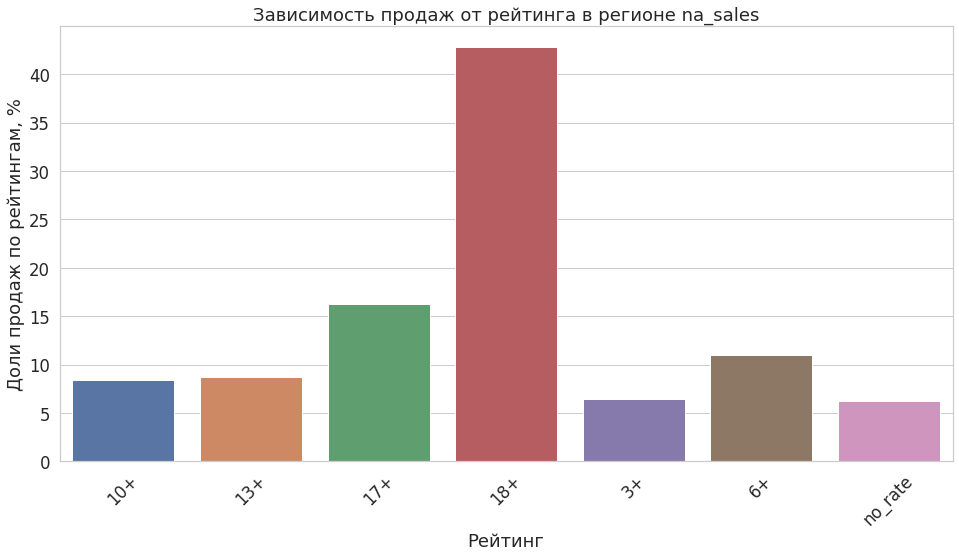

In [58]:
# Создадим функцию, которая построит нам графики.
def rating_chart(country):
    data = rating_agregation
    x = 'rating'
    y = country
    
    sns.barplot(data=data, x=x, y=y) 
    
    plt.title(f'Зависимость продаж от рейтинга в регионе {country}')
    plt.xlabel('Рейтинг')
    plt.ylabel('Доли продаж по рейтингам, %')
    plt.xticks(rotation=45)
    plt.show()

rating_chart('na_sales')

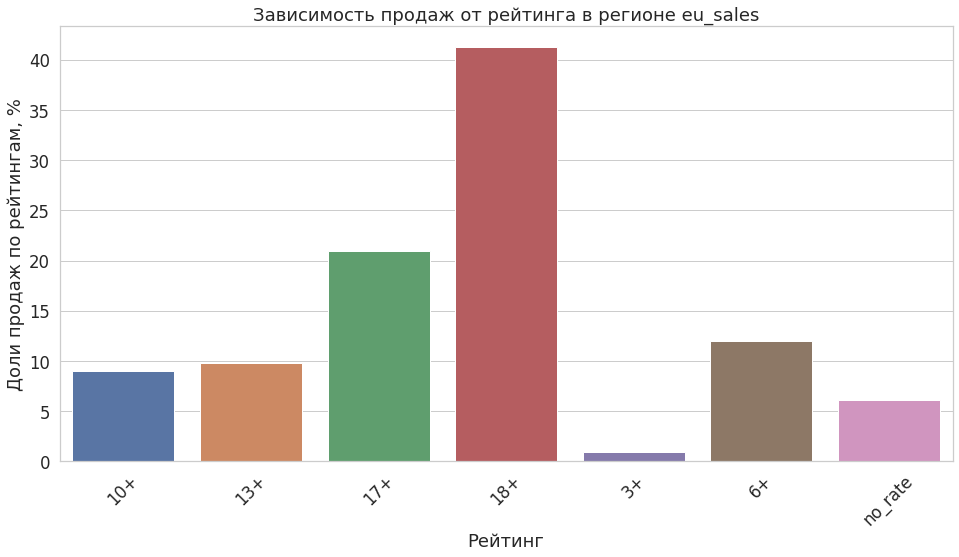

In [59]:
rating_chart('eu_sales')

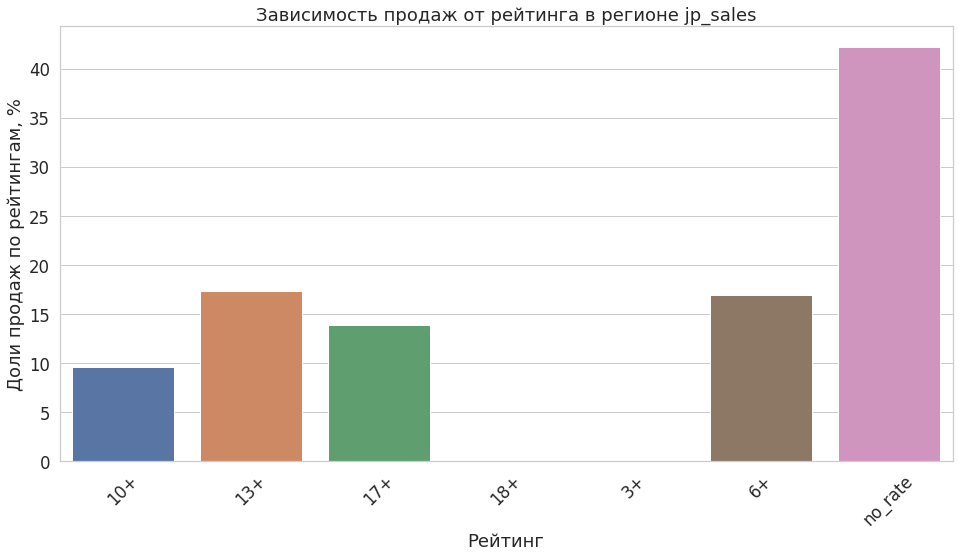

In [60]:
rating_chart('jp_sales')

В северной Америке наибольшая доля продаж приходится на игры, у которых есть рейтинг AO(18+). На втором месте - игры с рейтингом М(17+). Совсем незначительная доля приходится на все остальные рейтинги, а тажке продажи игр без рейтинга.

Схожая картина наблюдается в Европе. Там также в лидерах продаж игры с рейтингом АО и М.

А вот Япония и в этом вопросе решила отличиться от всех. В этой стране самую высокую долю продаж имеют игры без рейтинга! Для игр с рейтингом в Японии лидируют Е(6+) и Т(13+)

###  Вывод

**Портрет североамериканского пользователя.**

Предпочитает играть на приставках S4, XOne и X360. Отдает предпочтения шутерам, спортивным играм и платформерам. Североамериканский пользователь скорее выберет игры, у которых есть рейтинг USRB, и отдаст предпочтение играм с рейтингом AO(18+) и М(17+).

**Портрет европейского пользователя.**

Геймеры в Европе предпочитают приставки компании Sony. В жанровых предпочтениях они мало отличаются от американских, разве что вместо платформеров предпочитают погонять на компьютерных тачках. Также как и американские пользователи, геймеры из Европы отдат предпочтения играм, у которых есть рейтинг USRB. Шанс получить высокие продажи в Европе есть у игр с рейтингом: AO(18+) и М(17+).

**Портрет японского пользователя.**  

Геймеры в Японии предпочитают портативные игровые устройства. А если и будут покупать игровую приставку, то скорее всего, не американскую. Их самый любимый жанр - настолки. И японцам абсолютно все равно, если ли у игры рейтинг USRB или нет. Главное, чтобы геймплей был захватывающим.

##  Проверка гипотез

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Формулировка нулевых и альтернативных гипотез.
1. Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC разные.

1. Средние пользовательские рейтинги жанров Action и Sports одинаковые;
2. Средние пользовательские рейтинги жанров Action и Sports разные.

Так как мы будем проверять гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, будем использовать метод: scipy.stats.ttest_ind().

Для обоих гипотез выберем пороговое значение alpha в 5%.

Чтобы определиться использовать ли параметр equal_var в тесте, нам необходимо расчитать дисперсию для каждой из совокупностей и сравнить их. Если дисперсии будет значительно отличаться, equal_var будет необходимо взять со значений False.

Подготовим выборки. Учтем, что в пользовательских оценках у нас изначально содеражились значения Nan, с которыми модуль scipy, к сожалению, работать не умеет.

In [61]:
# Актуализируем данные.
df = df[df['year_of_release'] >= 2013]

# Подготовим выборки. Возьмем только значения без nan
xbox_one = df[df['platform'] == 'XOne']
xbox_one = xbox_one[xbox_one['user_score'].isna() == False]['user_score']

pc = df[df['platform'] == 'PC']
pc = pc.loc[pc['user_score'].isna() == False]['user_score']

action = df[df['genre'] == 'Action']
action = action.loc[action['user_score'].isna() == False]['user_score']

sports = df[df['genre'] == 'Sports']
sports = sports.loc[sports['user_score'].isna() == False]['user_score']

In [62]:
# Рассчитаем дисперсию для выборок. 
var_xbox_one = np.var(xbox_one, ddof=1)
var_pc = np.var(pc, ddof=1)

var_action = np.var(action, ddof=1)
var_sports = np.var(sports, ddof=1)

print(var_xbox_one, var_pc)
print(var_action, var_sports)

1.9069968429360695 3.035892752408882
1.7693609042482705 3.180612814465409


Дисперсии различаются более, чем на 30%. В тесте будем использовать equal_var=False. Проведем тестирование первой гипотезы.

In [63]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    xbox_one, 
    pc,
    equal_var = False
)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


У нас не получилось отвергнуть нулевую гипотезу: "средние пользовательские рейтинги платформ Xbox One и PC одинаковые". Проведем тестирование второй гипотезы

In [64]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    action, 
    sports,
    equal_var = False
)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.4460039700704315e-20
Отвергаем нулевую гипотезу


Данные свидетельствуют, что нулевая гипотеза не выполняется, следовательно подтверждается альтернативная гипотеза: "средние пользовательские рейтинги жанров Action и Sports разные".

### Вывод

Мы проверили проверку двух гипотез, в ходе которой на не удалось отвергнуть гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. В тоже время мы отвергли нулевую гипотезу о равенстве средних пользовательских рейтингов жанров Action и Sports разные", что привело нас к подтверждению альтернативной гипотезы, о том, что средние пользовательские рейтинги жанров Action и Sports разные.

## Общий вывод

Во время исследования мы выявили следующие закономерности:

1. Рынок компьютерных игр пережил период резкого роста, падания и с 2013 года вышел на плато.
2. Наибольшие суммарные продажи за все время показали 6 платформ PS2, X360, PS3, Wii, DS, PS.
3. Среднее время жизни игровой платформы составляет десть лет.
4. В актуальный период лидеры-платформы по продажам компьютерных игр: PS4, PS3, XOne, 3DS, X360.
5. Платформа PS4 - абсолютный лидер. Ее ближайший конкурент XOne на данный момент времени существенно проигрывает в продажах.
6. Нам не удалось выявить зависимость продаж компьютерных игр от оценок пользователей и критиков, это было связано с нехваткой данных.
7. В топ-3 самых прибыльных жанров вошли игры жанров Shooter, Sports, Platform и Role-Playing.
8. Антитоп по продажам заняли игры в жанре Misc, Simulation, Puzzle, Strategy, Adventure.
9. Американские пользователи предпочитают приставки S4, XOne и X360. Отдает предпочтения таким жанрам, как Action, Sport и Shooter. Для них имеет значение, если ли у игры рейтинг USRB.
10. Европейские пользователи предпочитают приставки компании Sony. В жанровых предпочтениях они мало отличаются от американских и отдают предпочтение играм, у которых есть рейтинг USRB. Шанс получить высокие продажи в Европе есть у игр с рейтингом: 6+(E) и 17+(М).
11. Японские пользователи предпочитают портативные игровые устройства, не любят американские приставки. Больше всего играют в настольные игры. И не обращают внимание на рейтинг USRB.
12. Гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые - получила подтверждение.
13. Гипотеза: средние пользовательские рейтинги жанров Action и Sports разные, также получила свое подтверждение, через отвержение нулевой гипотезы.

## Чек-лист готовности проекта

- [x]  файл открыт
- [x]  файл изучен (выведены первые строки, метод info())
- [x]  изменены название столбцов (приведены к нижнему регистру)
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  определены пропущенные значения
- [x]  описаны причины, которые могли привести к пропускам
- [x]  проанализирована аббревиатура 'tbd' в столбце с оценкой пользователей
- [x]  описано, как обработать аббревиатуру 'tbd'
- [x]  заполнены пропущенные значения
- [x]  посчитаны и записаны в отдельный столбец суммарные продажи во всех регионах
- [x]  проанализировано, сколько игр выпускалось в разные годы
- [x]  есть ответ на вопрос: важны ли данные за все периоды?
- [x]  проанализировано, как менялись продажи по платформам 
- [x]  выбраны платформы с наибольшими суммарными продажами и построены распределение по годам
- [x]  есть ответ на вопрос: за какой характерный срок появляются новые и исчезают старые платформы?
- [x]  на основе предыдущих пунктов исследования определен актуальный период
- [x]  есть ответ на вопрос: какие платформы лидируют по продажам, растут или падают? 
- [x]  выбраны несколько потенциально прибыльных платформ
- [x]  построен график «ящик с усами» по глобальным продажам игр в разбивке по платформам
- [x]  описан результат после построения графика
- [x]  проанализировано как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков
- [x]  сформулированы выводы
- [x]  выводы соотнесены с продажами игр на других платформах
- [x]  построено общее распределение игр по жанрам
- [x]  есть ответ на вопросы: что можно сказать о самых прибыльных жанрах? выделяются ли жанры с высокими и низкими продажами?
- [x]  определены пользователи для каждого региона (NA, EU, JP)
- [x]  определены самые популярные платформы (топ-5)
- [x]  описаны различия в долях продаж
- [x]  определены самые популярные жанры (топ-5)
- [x]  пояснена разница между ними
- [x]  есть ответ на вопрос: влияет ли рейтинг ESRB на продажи в отдельном регионе?
- [x]  проверена гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- [x]  проверена гипотеза: средние пользовательские рейтинги жанров Action и Sports разные
- [x]  есть пояснение, как сформулирована нулевая и альтернативная гипотезы
- [x]  есть пояснение, какой критерий применен для проверки гипотез и почему
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод